In [1]:
import warnings
import yaml
import math

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.filterwarnings('ignore')

# Описание задачи

Задача предсказания цен на квартиры в Москве - задача регрессии

Она может быть важна для агентств недвижимости, инвесторов, застройщиков и других участников рынка недвижимости. На основе предсказаний цен можно делать более точные прогнозы доходности инвестиций, планировать стратегии продаж и закупки объектов недвижимости, а также определять ценообразование на рынке.

# Описание данных:

- author - автор объявления

- author_type - тип автора (real_estate_agent - агентство недвижимости, homeowner - собственник, realtor - риелтор, official_representative - ук оф.представитель, representative_developer - представитель застройщика, developer - застройщик, unknown - без указанного типа)

- link - ссылка на объявление

- city - город, в котором находится квартира

- deal_type - тип объявления, к примеру, долгосрочная, краткосрочная аренда, продажа ("rent_long", "rent_short", "sale")

- accommodation_type - вид жилья, к примеру, квартира, комната, дом, часть дома, таунхаус ("flat", "room", "house", "house-part", "townhouse")

- floor - этаж, на котором находится квартира

- floors_count - общее количество этажей в доме

- rooms_count - количество комнат в квартире

- total_meters - общая площадь

- price_per_m2 - стоимость на квадратный метр

- **price - стоимость квартиры (целевая переменная)**

- district - район, в котором находится квартира

- street - улица

- underground - метро

- residential_complex - название жилого комплекса

- line - ветка, на которой находится метро

- area - округ, в котором находится квартира

- eco_rating - экологический рейтинг района, в котром находится квартира

- insufficient_infrastructure - недостаточно инфраструктуры, %

- convenient_for_life - удобность для жизни, %

- very_convenient_for_life - очень комфортный для жизни, %

- few_entertainment - недостаточно мест для досуга и развлечений, %

- cultural - оценка культурных мест, %

- entertainment - оценка развлекательных мест, %

- cultural_entertainment - оценка культурно-развлекательных мест, %

- residential_infrastructure_rating - рейтинг жилой инфраструктуры 

- entertainment_infrastructure_rating - рейтинг развлекательной инфраструктуры 

- square - площадь района

- population - численность населения в районе

- housing_fund_area - площадь жилфонда

- line_count - количество пересадочных станций

- author_count - количество объявлений у автора

- author_more - флаг, который показывает что у автора больше двух объявлений

- floor_position - позиция этажа (2 - последний этаж, 1 -первый этаж, 0 - середина)

- house_category - категория дома в зависимости от количества этажей (1 - малоэтажные (1 - 2 этажа), 2 - средней этажности (3 - 5 этажей), 3 - многоэтажные (6-10), 4 - повышенной этажности (11 - 16 этажей), 5 - высотные (16-50 этажей), 6 - очень высотные (более 50 этажей))
- population_density - плотность населения района

In [2]:
config_path = '../config/params.yaml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preprocessing = config['preprocessing']

In [3]:
def read_df(path: str, sep: str = None, encoding: str = None) -> pd.DataFrame:
    """
    Читает файл CSV и возвращает его содержимое в виде датафрейма.
    :param path: путь к папке, содержащей файлы CSV
    :param sep: опциональный разделитель столбцов
    :param encoding: опциональная кодировка файла
    :return: датафрейм
    """
    df = pd.read_csv(path,
                     sep=sep,
                     encoding=encoding)
    return df

In [4]:
cian = read_df(preprocessing['final_df'])

In [5]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159 entries, 0 to 12158
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   author                          12159 non-null  object 
 1   floor                           12159 non-null  int64  
 2   floors_count                    12159 non-null  int64  
 3   rooms_count                     12159 non-null  int64  
 4   total_meters                    12159 non-null  float64
 5   price                           12159 non-null  int64  
 6   district                        12159 non-null  object 
 7   street                          12159 non-null  object 
 8   underground                     12159 non-null  object 
 9   residential_complex             12159 non-null  object 
 10  line                            12159 non-null  object 
 11  area                            12159 non-null  object 
 12  eco_rating                      

In [6]:
cian.describe()

,floor,floors_count,rooms_count,total_meters,price,eco_rating,insufficient_infrastructure,convenient_for_life,very_convenient_for_life,few_entertainment,...,top_residential_infrastructure,square,population,housing_fund_area,line_count,author_count,author_more,floor_position,house_category,population_density
count,12159.000000,12159.000000,12159.000000,12159.000000,1.215900e+04,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,...,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000
mean,10.019409,19.369603,2.336376,90.149736,5.733351e+07,3.955424,14.153055,35.186035,25.764372,27.925076,...,42.246566,7.490138,78669.403158,1475.440818,1016.563615,232.953039,0.880829,0.264660,4.104367,8769.839283
std,9.980510,14.136630,1.587970,72.565763,1.002343e+08,3.099170,16.821700,29.110715,28.697559,34.081925,...,40.804668,6.483891,56756.517451,1133.809914,529.242696,356.605949,0.324003,0.640412,1.187357,6222.565632
min,-1.000000,-1.000000,-1.000000,-1.000000,2.450000e+06,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,9.000000,1.000000,38.200000,1.110000e+07,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.110000,27672.000000,385.500000,881.000000,20.000000,1.000000,0.000000,3.000000,4604.810000
50%,7.000000,17.000000,2.000000,64.700000,2.289222e+07,5.000000,9.000000,32.000000,15.000000,13.000000,...,33.000000,7.570000,83712.000000,1416.400000,1086.000000,86.000000,1.000000,0.000000,5.000000,9882.480000
75%,14.000000,25.000000,4.000000,122.800000,6.344312e+07,6.000000,21.000000,60.000000,52.000000,60.000000,...,84.000000,11.700000,127819.000000,2312.700000,1440.000000,262.000000,1.000000,0.000000,5.000000,13225.090000
max,92.000000,97.000000,5.000000,941.700000,2.107580e+09,9.000000,100.000000,100.000000,100.000000,100.000000,...,118.000000,27.570000,253943.000000,4523.000000,1664.000000,1282.000000,1.000000,2.000000,6.000000,30428.770000


- самая маленькая квартира -1, потому что этими значениями заполнены пропуски

- самая большая в самой большой квартире 941.7 квадратных метров


In [7]:
cian.describe(include=object)

,author,district,street,underground,residential_complex,line,area
count,12159,12159,12159,12159,12159,12159,12159
unique,1643,124,1254,288,755,17,11
top,ПИК,None,None,None,None,None,None
freq,1089,1277,2405,295,4502,1633,2900


- больше всего квартир выкладывает компания ПИК

перевод данных в соотвествующие типы

In [8]:
def transform_types(data: pd.DataFrame, change_col_types: dict) -> pd.DataFrame:
    """
    Преобразование признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return: датафрейм
    """
    return data.astype(change_col_types, errors="raise")

In [9]:
cian = transform_types(data=cian, change_col_types=preprocessing['change_col_types'])

In [10]:
cian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159 entries, 0 to 12158
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   author                          12159 non-null  category
 1   floor                           12159 non-null  int32   
 2   floors_count                    12159 non-null  int32   
 3   rooms_count                     12159 non-null  int32   
 4   total_meters                    12159 non-null  float32 
 5   price                           12159 non-null  int64   
 6   district                        12159 non-null  category
 7   street                          12159 non-null  category
 8   underground                     12159 non-null  category
 9   residential_complex             12159 non-null  category
 10  line                            12159 non-null  category
 11  area                            12159 non-null  category
 12  eco_rating        

In [11]:
cian.isna().sum()

author                            0
floor                             0
floors_count                      0
rooms_count                       0
total_meters                      0
price                             0
district                          0
street                            0
underground                       0
residential_complex               0
line                              0
area                              0
eco_rating                        0
insufficient_infrastructure       0
convenient_for_life               0
very_convenient_for_life          0
few_entertainment                 0
cultural                          0
entertainment                     0
cultural_entertainment            0
top_residential_infrastructure    0
square                            0
population                        0
housing_fund_area                 0
line_count                        0
author_count                      0
author_more                       0
floor_position              

In [12]:
def read_df(path: str,
            sep: str = None,
            encoding: str = None,
            csv: bool = True) -> pd.DataFrame:
    """
    Читает файл CSV и возвращает его содержимое в виде датафрейма.
    :param path: путь к папке, содержащей файлы CSV
    :param sep: опциональный разделитель столбцов
    :param encoding: опциональная кодировка файла
    :param csv: флаг, который указывает в каком формате считывать файл
    :return: датафрейм
    """
    if csv == True:
        df = pd.read_csv(path, sep=sep, encoding=encoding)
    else:
        df = gpd.read_file(path)
    return df

In [13]:
geo_gpd = read_df('../data/geo/geo_msc.geojson', csv=False)

In [14]:
def df_merge(df: pd.DataFrame,
             data: pd.DataFrame,
             left_on: str,
             right_on: str,
             how: str,
             columns: list = None) -> pd.DataFrame:
    """
    Объединяет два датафрейма на основе заданных столбцов и возвращает 
    результат объединения
    :param df: основной датафрейм для объединения
    :param data: датафрейм, который будет объединен с основным датафреймом
    :param left_on: имя столбца или столбцов в основном датафрейме,
     используемых для объединения
    :param right_on: имя столбца или столбцов в датафрейме data,
     используемых для объединения
    :param how: тип объединения
    :param columns: список столбцов из data, которые будут включены
     в результирующий датафрейм
    :return: датафрейм
    """
    if columns is None:
        columns = list(data.columns)

    df = df.merge(data[columns], left_on=left_on, right_on=right_on,
                  how=how).drop_duplicates()
    return df

In [15]:
def count_value(df: pd.DataFrame, column: str, name_columns: list) -> pd.DataFrame:
    """
    Подсчитывает, сколько раз встречается значение в указанном столбце датафрейма.
    :param df: исходный датафрейм
    :param district_column: имя столбца
    :param name_columns: названия колонок
    :return: датафрейм
    """

    district_counts = df[column].value_counts().reset_index()
    district_counts.columns = name_columns

    return district_counts

In [16]:
geo_gpd = df_merge(df=geo_gpd,
                   data=count_value(cian, 'district', ['district', 'count_district']),
                   columns=['district', 'count_district'],
                   left_on='district',
                   right_on='district',
                   how='left')

In [17]:
def df_groupby(df: pd.DataFrame, group_column: str,
                    column: str, count: bool = False) -> pd.DataFrame:
    """
    Вычисляет среднее значение по в зависимости от другого признака
    :param df: исходный датафрейм
    :param group_column: имя столбца с типами авторов
    :param column: имя столбца с ценами
    :return: датафрейм со средней ценой по типам авторов
    """
    if count == True:
        df = df.groupby(
        group_column)[column].count().reset_index()
    else:
        df = df.groupby(
            group_column)[column].mean().reset_index()
    return df

In [18]:
geo_gpd = df_merge(df=geo_gpd,
                   data=df_groupby(cian, 'district', 'price'),
                   columns=['district', 'price'],
                   left_on='district',
                   right_on='district',
                   how='left')

In [19]:
geo_gpd = df_merge(df=geo_gpd,
                   data=cian,
                   columns=[
                       'population_density', 'very_convenient_for_life',
                       'convenient_for_life', 'district'
                   ],
                   left_on='district',
                   right_on='district',
                   how='left')

In [20]:
def get_sort_barplot(data: pd.DataFrame,
                     x: str,
                     y: str,
                     ascending: bool = False,
                     limit: int = None,
                     xlabel: str = None,
                     ylabel: str = None,
                     title: str = None,
                     order: bool = False,
                     figsize: tuple = (10, 7),
                     rotation: bool = False) -> None:
    """
    Строит график столбчатой диаграммы с сортировкой по заданному столбцу
    :param data: датафрейм
    :param x: параметр по x
    :param y:параметр по xy
    :param ascending: флаг сортировки
    :param limit: количество выводимых записей
    :param xlabel: название по x
    :param ylabel: название по y
    :param title: азвание графика
    :param order: флаг нужно ли делать сортировку
    :param figsize: размер графика
    :param rotation: флаг для поворота названий значений на 90 градусов
    :return: None
    """
    plt.figure(figsize=figsize)
    if order == True:
        ax = sns.barplot(x=x,
                         y=y,
                         data=data,
                         order=data.sort_values(y, ascending=ascending)[x][:limit])
    else:
        ax = sns.barplot(x=x,
                         y=y,
                         data=data)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    if rotation == True:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

In [21]:
def create_boxplot(data: pd.DataFrame,
                   x: str,
                   y: str,
                   title: str = None,
                   xlabel: str = None,
                   ylabel: str = None,
                   ylim: tuple = None,
                   rotation: bool = False,
                   order=None,
                   figsize: tuple = (10, 7)) -> None:
    """
    Создает boxplot на основе данных.
    :param data: данные для создания диаграммы
    :param x: имя столбца для оси x
    :param y: имя столбца для оси y
    :param title: заголовок диаграммы 
    :param xlabel: название оси x 
    :param ylabel: название оси y 
    :param ylim: пределы оси y в формате 
    :param rotation: флаг для поворота названий значений на 90 градусов
    :param order: порядок районов на оси x (по умолчанию None)
    :param figsize: размеры фигуры (по умолчанию (13, 7))
    :return: None
    """

    plt.figure(figsize=figsize)
    ax = sns.boxplot(x=x, y=y, data=data, order=order)
    plt.title(title, fontsize=15, pad=10)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    if ylim is not None:
        ax.set_ylim(ylim)
    if rotation == True:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.show()

In [22]:
def plot_geo_gpd_data(geo_gpd: pd.DataFrame, column: str, title: str,
                      legend_label: str) -> None:
    """
    Создает географическую диаграмму на основе GeoDataFrame.
    :param geo_gpd: geopandas.GeoDataFrame, географические данные
    :param column: str, имя столбца в GeoDataFrame, которое будет отображаться цветом
    :param title: str, заголовок диаграммы
    :param legend_label: str, название легенды
    :return: None
    """

    fig, ax = plt.subplots(figsize=(20, 8))

    geo_gpd.plot(ax=ax,
                 column=column,
                 linewidth=1,
                 cmap='inferno',
                 legend=True,
                 legend_kwds={
                     'label': legend_label,
                     'orientation':  'vertical'
                 })

    ax.set_aspect('equal')
    plt.title(title, fontsize=14, pad=10)

    plt.show()

In [23]:
def create_histogram(df: pd.DataFrame,
                                    x: str,
                                    title=None,
                                    xlabel: str = None,
                                    ylabel: str = None,
                                    figsize: tuple = (9, 7),
                                    kde: bool = False) -> None:
    """
    Создает гистограмму количества квартир в зависимости от этажности дома.
    :param df: исходный датафрейм
    :param x: имя столбца по x
    :param title: заголовок гистограммы
    :param xlabel: название оси x
    :param ylabel: название оси y
    :param figsize: размеры фигуры
    :param kde: флаг указывающий на примененние параметра kde
    :return: None
    """

    plt.figure(figsize=figsize)

    sns.histplot(data=df, x=x, color='purple', kde=kde)
    plt.title(title, fontsize=15, pad=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.show()

In [24]:
def create_heatmap(df: pd.DataFrame,
                   columns: list,
                   title: str = None) -> None:
    """
    Создает тепловую карту корреляции между выбранными столбцами датафрейма.
    :param df: pd.DataFrame, исходный датафрейм
    :param columns: list, список имен столбцов для построения тепловой карты
    :param title: str, заголовок тепловой карты (по умолчанию None)
    :return: None
    """

    plt.subplots(figsize=(6, 3))

    heatmap = sns.heatmap(df[columns].corr(),
                          annot=True,
                          vmin=-1,
                          vmax=1,
                          center=0)

    plt.title(title, fontsize=15, pad=10)
    plt.show()

# Проверяемые гипотезы



1. Количество продаваемых квартир больше в определённых районах

2. Цена квартиры зависит от района, в котором находится квартира

3. Цена зависит от этажности дома

4. Цена зависит от того, на каком этаже находится квартира

5. Цена зависит от того, что квартира находится на первом или последнем этаже

6. Чем больше население района, тем дороже квартира

7. Есть зависимость между ценой и оценкой комфорта в данном районе

8. Цена зависит от ветки, на которой находится метро

# Проверка гипотез

## Гипотеза 1
Количество продаваемых квартир больше в определённых районах

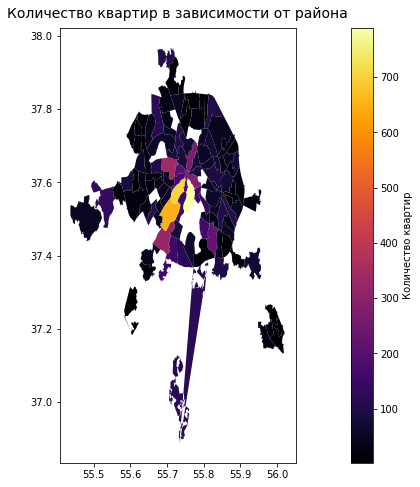

In [25]:
plot_geo_gpd_data(geo_gpd, column='count_district',
                  title='Количество квартир в зависимости от района',
                  legend_label='Количество квартир')

- Чем ближе к центру, тем больше квартир там продаётся

## Гипотеза 2
Цена квартиры зависит от района, в котором находится квартира

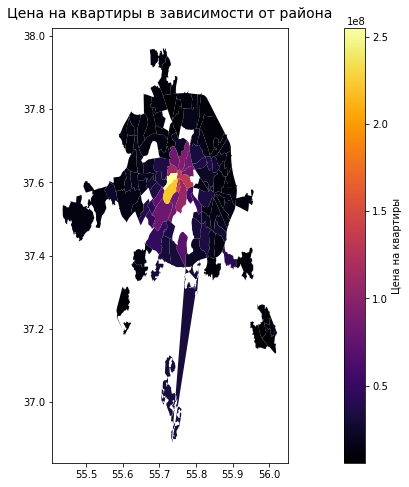

In [26]:
plot_geo_gpd_data(geo_gpd, column='price',
                  title='Цена на квартиры в зависимости от района',
                  legend_label='Цена на квартиры')

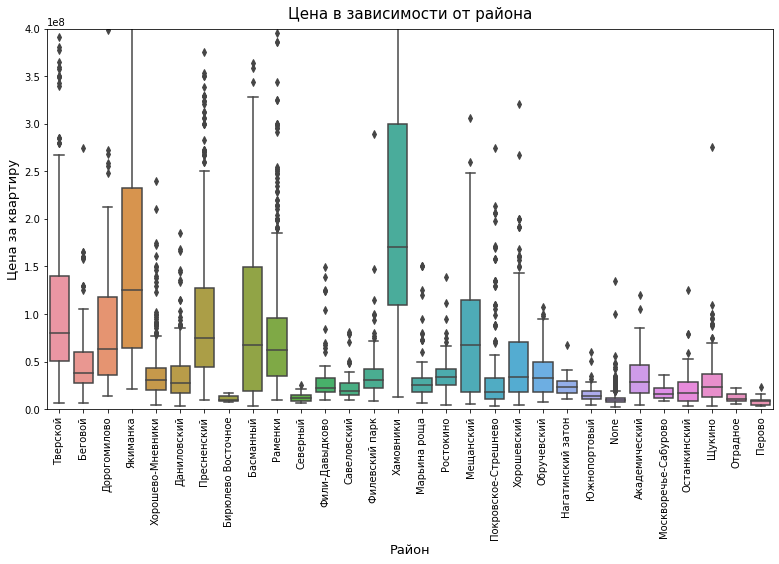

In [27]:
create_boxplot(data=cian, x='district', y='price',
                            order=cian['district'].unique()[:30],
                            title='Цена в зависимости от района',
                            xlabel='Район', ylabel='Цена за квартиру',
                            ylim=(0, 400000000), figsize=(13, 7), rotation=True)

- в центре квартиры дороже всего

## Гипотеза 3
Цена зависит от этажности дома

Дома разделаются в зависимости от количества этажей на категории:

1 - малоэтажные (1 - 2 этажа)

2 - средней этажности (3 - 5 этажей)

3 - многоэтажные (6-10)

4 - повышенной этажности (11 - 16 этажей)

5 - высотные (16-50 этажей)

6 - очень высотные (более 50 этажей)

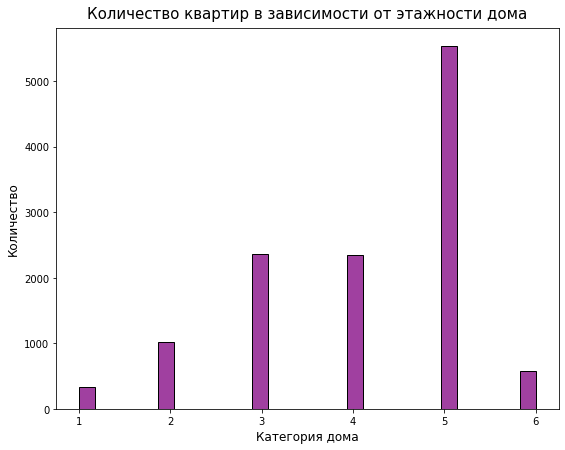

In [28]:
create_histogram(df=cian,
                 x='house_category',
                 title='Количество квартир в зависимости от этажности дома',
                 xlabel='Категория дома',
                 ylabel='Количество',
                 figsize=(9, 7))

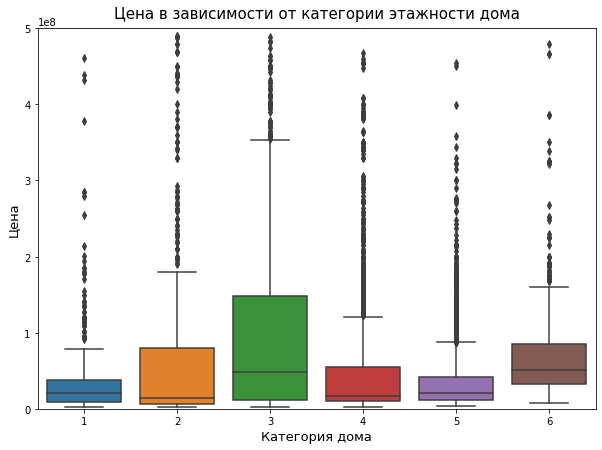

In [29]:
create_boxplot(data=cian,
               x='house_category',
               y='price',
               title='Цена в зависимости от категории этажности дома',
               xlabel='Категория дома',
               ylabel='Цена',
               ylim=(0, 500000000))

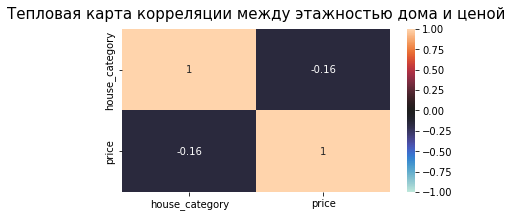

In [30]:
create_heatmap(df=cian, columns=['house_category', 'price'],
                   title='Тепловая карта корреляции между этажностью дома и ценой')

- самые дорогие квартиры в домах, в которых 6-10 этажей

- в очень высотных домах квартиры по цене находятся на втором месте. В таких домах начальная цена квартир самая дорогая

- в остальных домах средняя цена примерно одинакова, различие только в разбросе цен, возможно она связана с тем на каком этаже находится квартира

- больше всего квартир в домах от 16 до 40 этажей, возможно в связи экономии места

## Гипотеза 4
Цена зависит от того, на каком этаже находится квартира

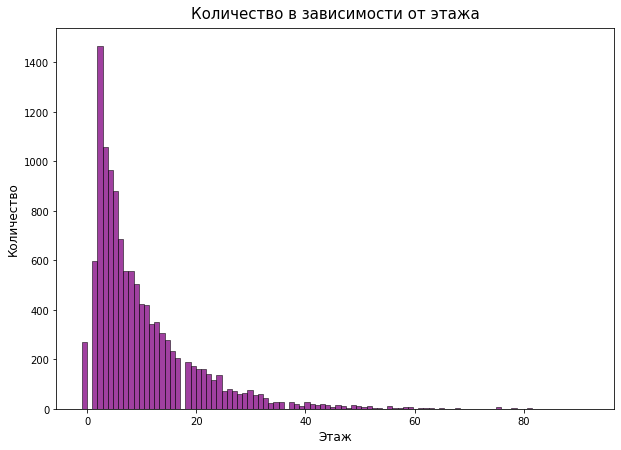

In [31]:
create_histogram(df=cian,
                 x='floor',
                 title='Количество в зависимости от этажа',
                 xlabel='Этаж',
                 ylabel='Количество',
                 figsize=(10, 7))

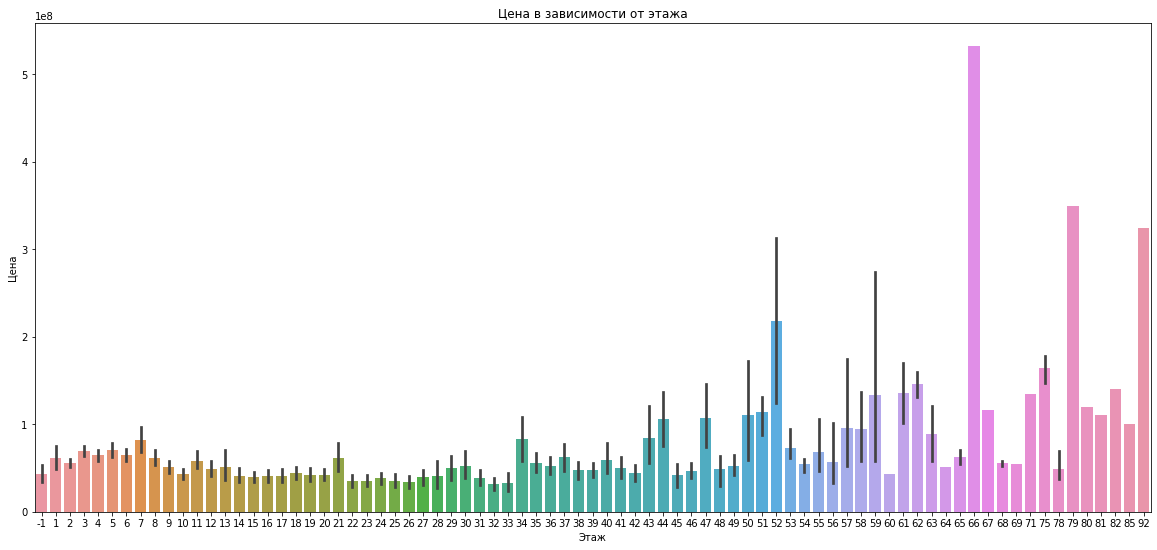

In [32]:
get_sort_barplot(data=cian,
                 x='floor',
                 y='price',
                 xlabel='Этаж',
                 ylabel='Цена',
                 title='Цена в зависимости от этажа',
                 figsize=(20,9))

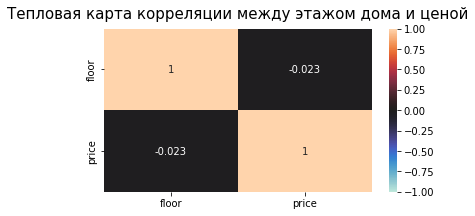

In [33]:
create_heatmap(df=cian, columns=['floor', 'price'],
                   title='Тепловая карта корреляции между этажом дома и ценой')

- чем ниже этаж, тем больше количество квартир

- квартиры на очень высоких этажах встречаются редко, возможно поэтому цена на них дороже

- в среднем самые дорогие квартиры на 7 этаже

- в среднем самые дешёвые квартиры на 32 этаже, возможно это связано с тем, что это последний этаж в некоторых домах

- в высоких домах (скорее всего новостройки) до 40 этажей, чем выше этаж, тем ниже цена. Возможно, это связано с тем что людям некомфортно жить так высоко

## Гипотеза 5
Цена зависит от того, что квартира находится на первом или последнем этаже


0 - середина,

1 -первый этаж,

2 - последний этаж


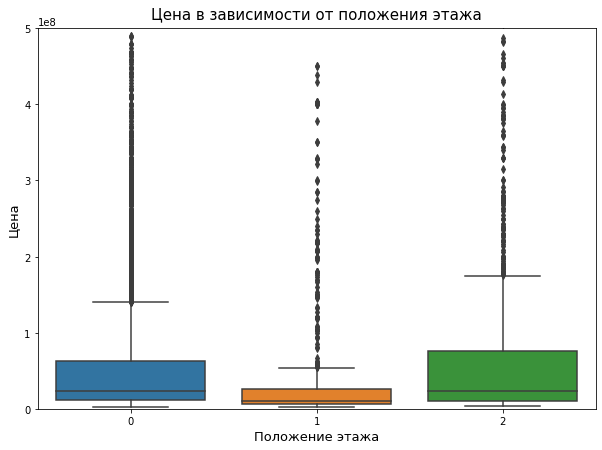

In [34]:
create_boxplot(data=cian,
               x='floor_position',
               y='price',
               title='Цена в зависимости от положения этажа',
               xlabel='Положение этажа',
               ylabel='Цена',
               ylim=(0, 500000000))

- квартиры на первом этаже самые дешёвые

- средняя цена квартир на последнем этаже примерно такая же, как и на других этажах, но имеется хвост в сторону увеличения цены, т к в некоторых домах последний этаж это пентхаус

- за счёт того, что обычные квартиры на последнем этаже меньше ценятся, начальная цена меньше чем на других этажах

## Гипотеза 6
Чем больше плотность население района, тем дороже квартира

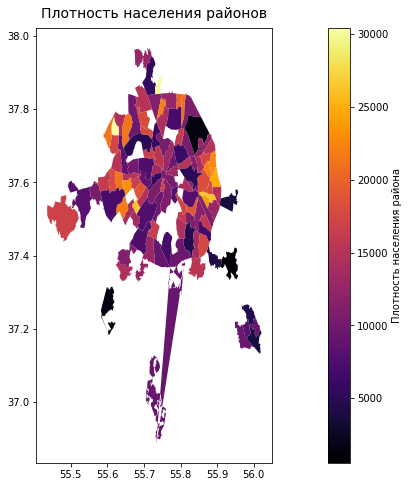

In [35]:
plot_geo_gpd_data(geo_gpd, column='population_density',
                  title='Плотность населения районов',
                  legend_label='Плотность населения района')

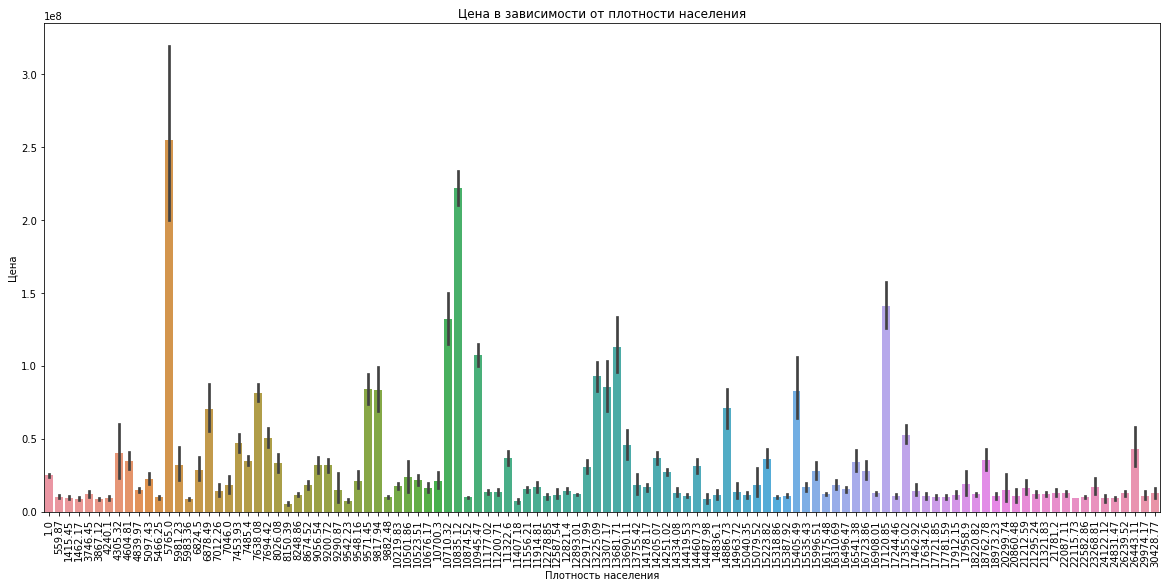

In [36]:
get_sort_barplot(data=cian,
                 x='population_density',
                 y='price',
                 xlabel='Плотность населения',
                 ylabel='Цена',
                 title='Цена в зависимости от плотности населения',
                 figsize=(20,9),
                 rotation=True)

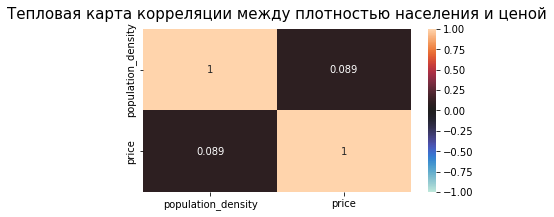

In [37]:
create_heatmap(
    df=cian,
    columns=['population_density', 'price'],
    title='Тепловая карта корреляции между плотностью населения и ценой')

- зависимости между ценой и плотностью населения нет

## Гипотеза 7
Есть зависимость между ценой и оценкой комфорта в данном районе

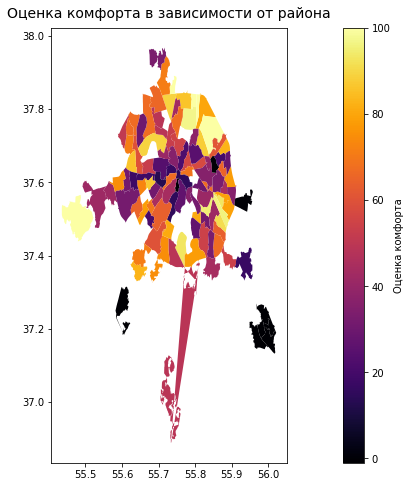

In [38]:
plot_geo_gpd_data(geo_gpd, column='convenient_for_life',
                  title='Оценка комфорта в зависимости от района',
                  legend_label='Оценка комфорта')

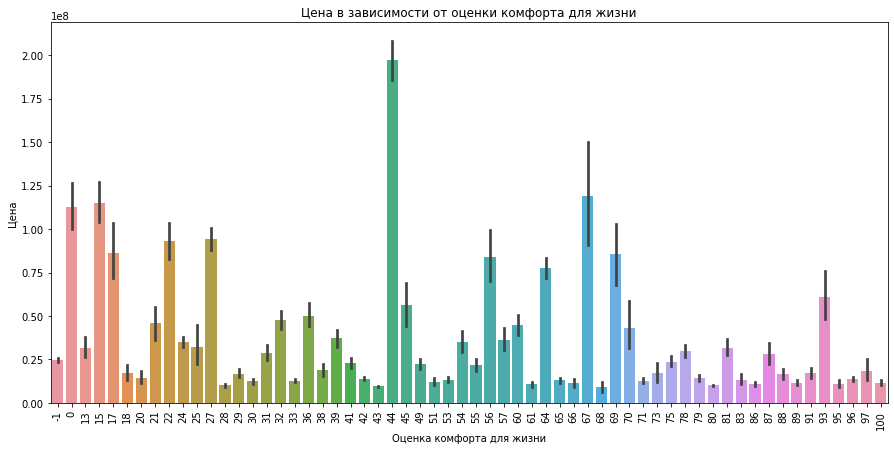

In [39]:
get_sort_barplot(data=cian,
                 x='convenient_for_life',
                 y='price',
                 xlabel='Оценка комфорта для жизни',
                 ylabel='Цена',
                 title='Цена в зависимости от оценки комфорта для жизни',
                 figsize=(15,7),
                 rotation=True)

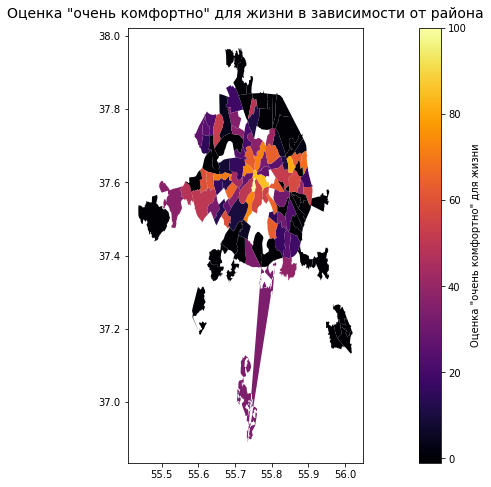

In [40]:
plot_geo_gpd_data(geo_gpd, column='very_convenient_for_life',
                  title='Оценка "очень комфортно" для жизни в зависимости от района',
                  legend_label='Оценка "очень комфортно" для жизни')

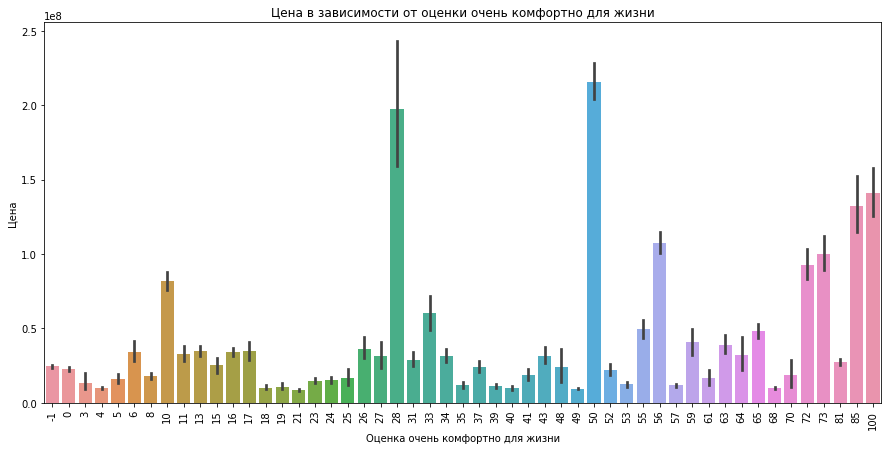

In [41]:
get_sort_barplot(data=cian,
                 x='very_convenient_for_life',
                 y='price',
                 xlabel='Оценка очень комфортно для жизни',
                 ylabel='Цена',
                 title='Цена в зависимости от оценки очень комфортно для жизни',
                 figsize=(15,7),
                 rotation=True)

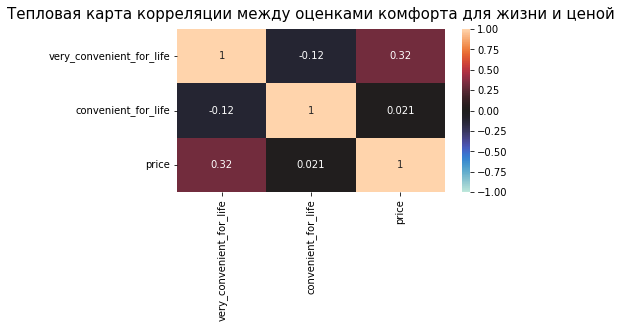

In [42]:
create_heatmap(
    df=cian,
    columns=['very_convenient_for_life', 'convenient_for_life', 'price'],
    title='Тепловая карта корреляции между оценками комфорта для жизни и ценой'
)


- критерий "очень комфортно для жизни" больше коррелирует с ценой, чем "комфортно для жизни"

## Гипотеза 8
Цена зависит от ветки, на которой находится метро

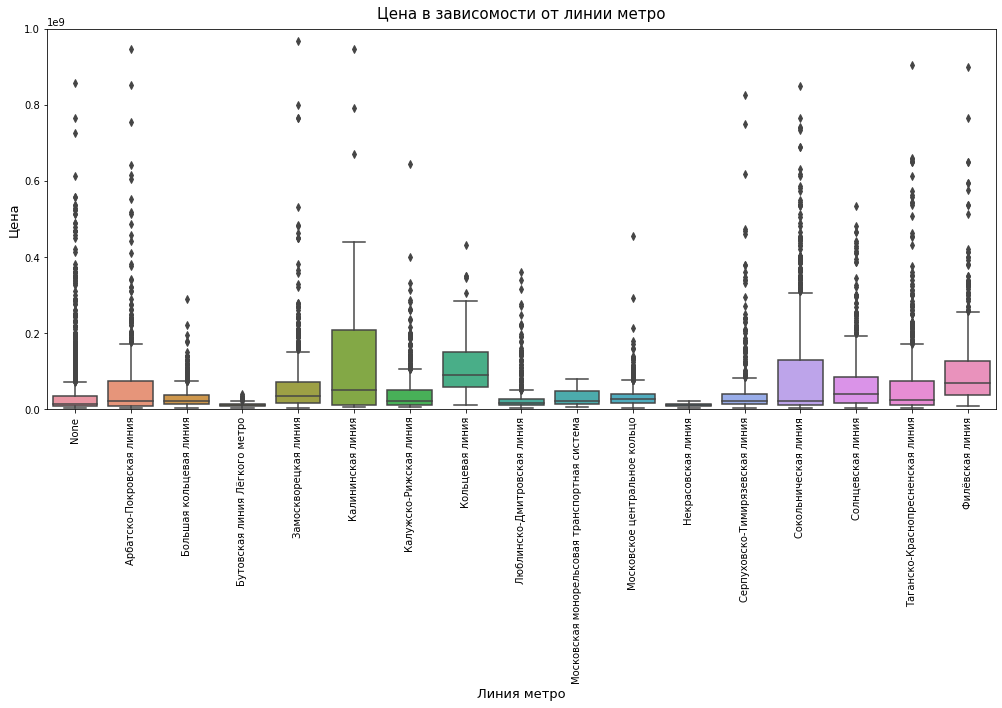

In [43]:
create_boxplot(data=cian,
               x='line',
               y='price',
               title='Цена в зависомости от линии метро',
               xlabel='Линия метро',
               ylabel='Цена',
               ylim=(0, 1000000000),
               rotation=True,
               figsize=(17, 7))

- линия метро влияет на цену квартиры

- на Кольцевой линии самый большой порог цены и самая высокая средняя цена

- на Калининской линии самый большой разброс цен, потому что она идёт от центра до края Москвы

- самая дешёвые квартиры на Некрасовской линии

# Выводы

- Чем ближе к центру, тем больше квартир там продаётся

- в центре квартиры дороже всего

- самые дорогие квартиры в домах, в которых 6-10 этажей

- в очень высотных домах квартиры по цене находятся на втором месте. В таких домах начальная цена квартир самая дорогая

- в остальных домах средняя цена примерно одинакова, различие только в разбросе цен, возможно она связана с тем на каком этаже находится квартира

- больше всего квартир в домах от 16 до 40 этажей, возможно в связи экономии места

- чем ниже этаж, тем больше количество квартир

- квартиры на очень высоких этажах встречаются редко, возможно поэтому цена на них дороже

- в среднем самые дорогие квартиры на 7 этаже

- в среднем самые дешёвые квартиры на 32 этаже, возможно это связано с тем, что это последний этаж в некоторых домах

- в высоких домах (скорее всего новостройки) до 40 этажей, чем выше этаж, тем ниже цена. Возможно, это связано с тем что людям некомфортно жить так высоко

- квартиры на первом этаже самые дешёвые

- средняя цена квартир на последнем этаже примерно такая же, как и на других этажах, но имеется хвост в сторону увеличения цены, т к в некоторых домах последний этаж это пентхаус

- за счёт того, что обычные квартиры на последнем этаже меньше ценятся, начальная цена меньше чем на других этажах

- линия метро влияет на цену квартиры

- на Кольцевой линии самый большой порог цены и самая высокая средняя цена

- на Калининской линии самый большой разброс цен, потому что она идёт от центра до края Москвы

- самая дешёвые квартиры на Некрасовской линии